# Introduction


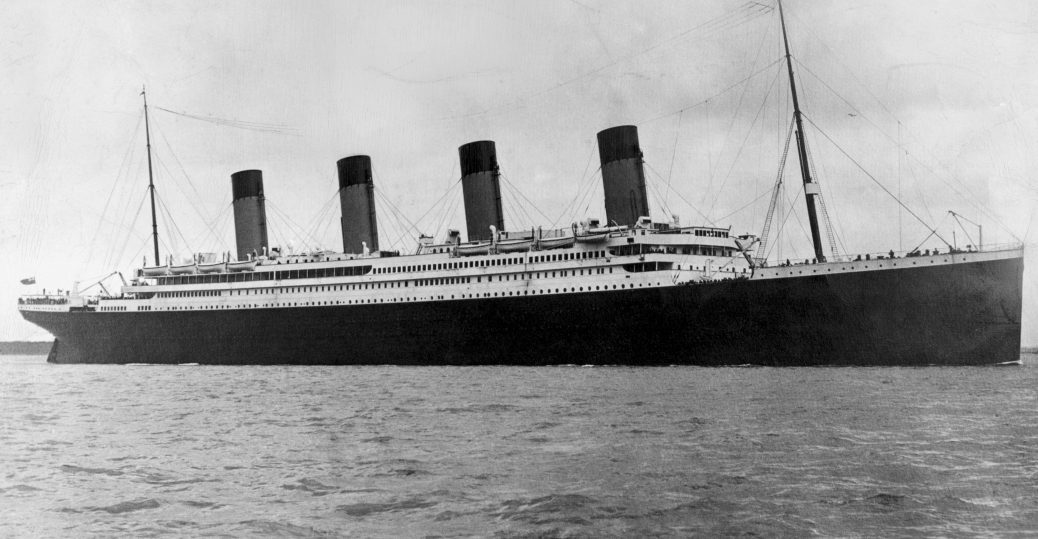

This is my first kernel in Kaggle.

In this notebook, I am making an attempt to **explore the Titanic dataset and predict the survival category** for respective passengers . My first and foremost objective is to **understand the given dataset at depth and apply appropriate techniques to transform it**. On a high level, I will follow the following basic steps like for any other data science problem and detail them out as I proceed:

1. Load test and training dataset and necessary python packages
2. Data quality assessment: Check for inconsistencies in the data - corrupt and / or missing values
3. Determine the best approach for handling each inconsistency while managing the associated trade-offs (e.g. ignore missing values or impute, which imputation method to apply etc.)
4. Transform the datasets (Both test and training data)
5. Perform exploratory data analysis and extract best features for classification
6. Apply different classification algorithms (Naive Bayes, SVM, and Decision Tree)
7. Conclusion

<font color = blue> Please scroll to the end to view the list of references. </font>

## 1. Load test and training dataset and necessary python packages

In [ ]:
# Load python packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import matplotlib as plt
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Load test and training data
test_df = pd.read_csv('../input/test.csv')
train_df = pd.read_csv('../input/train.csv')

In [ ]:
# Display test data
test_df.head()

In [ ]:
# Display training data
train_df.head()

Let's take a step back and see what we have in our training and test data set.

Firstly, the test data set does not have 'Survived' column. This means that we cannot determine our model accuracy based on our prediction for test data set. We will come to addressing this issue in a later section. But for now, let us answer some basic questions:

1. What is the volume of test data and training data respectively?
2. What is the ratio of volume of training data to that of test data?
3. Do we have any missing values? If yes, which columns?
4. Do we have any corrupt values? If yes, which columns?

As you might have guessed already, we are moving forward with data quality assessment. 

## 2. Data Quality Assessment

In [ ]:
# Volume of test data is 418 rows
test_df.count()

Quick observation: 'Age', 'Fare', and 'Cabin' have missing data. Next, let's look at the training dataset

In [ ]:
# Volume of training data is 891
train_df.count()

We will have to handle the missing values of 'Age', 'Cabin' and 'Embarked' but before we do that, we need to check for the ratio of volume of training / test dataset and for the presence of any corrupt data.

In [ ]:
# Computing ratio of training and test data sets
len(train_df) / (len(test_df) + len(train_df))

This means we have approximately 68% of training data and rest 32% as test data. This is close to a 70% - 30% split. Ideally, this ratio is acceptable in large data sets since the variance in different parameters can be compensated for. But for a small data set like the one we have, we will need to take care of our model accuracy. Also, it is again worth mentioning that we do not have the 'Survived' column in our test data set.
One important point to note here is that in a normal data science problem, at this point, one might consider collecting more data sources if possible which is why I believe this step is significant.

Let's move on and see if we have any corrupt data. I will first run some validations on training dataset and then re-execute the steps for test data.

In [ ]:
# Check if any duplicate rows are present in training data. 
# Checking with PassengerId as it should be unique
train_df['PassengerId'].duplicated().any()

In [ ]:
# Check data type of all columns in training data
train_df.dtypes

<font color = red> Let's check unique values in each of the columns and flag any abnormality.  </font>

## 3. Identifying best approach for handling corrupt data and / or missing values

Check for missing values. From above analysis, we already know that 'Age', 'Cabin' and 'Embarked' have missing values in training data.

In the below steps, I will first look at the proportion of missing values for each of the columns, then look at the shape of the data and determine which statistic can be a best replacement for imputation or if ignoring the column altogether is the best approach.

In [ ]:
# Handling missing values in 'Age'. 
train_df['Age'].isnull().sum()

In [ ]:
# Proportion of age data with missing values
train_df['Age'].isnull().sum() / len(train_df)

In [ ]:
train_df['Age'].hist(bins = 18, color = 'darkturquoise')

Age distribution is not normal. Also, the proportion of age data with missing values is huge. Hence the best approach is to impute the missing values with median age

In [ ]:
# Handling missing values in 'Cabin'. 
train_df['Cabin'].isnull().sum()

In [ ]:
# Proportion of Cabin data with missing values
train_df['Cabin'].isnull().sum() / len(train_df)

77% of the training data does not have this column value. Best approach will be to ignore this column for analysis as any method of imputation can induce error in our model.

In [ ]:
# Handling missing values in 'Emabarked'. 
train_df['Embarked'].isnull().sum()

In [ ]:
# Proportion of Embarked data with missing values
train_df['Embarked'].isnull().sum() / len(train_df)

In [ ]:
# Embarked is a categorical variable. Let's see its distribution
#train_df.plot(kind='bar', title ='Embarked classes',figsize=(15,10),legend=True, fontsize=12)
train_df.Embarked.value_counts().plot.barh(color = 'darkturquoise')

Clearly, majority passengers embarked from third station so we can either impute the two missing values with 'S' or choose to drop the two records. Both options seem viable. I will choose to impute with 'S' 

Now let's move ahead and do the same checks for test data

In [ ]:
# Handling missing values in 'Age'. 
test_df['Age'].isnull().sum()

In [ ]:
# Proportion of age data with missing values
test_df['Age'].isnull().sum() / len(test_df)

In [ ]:
test_df['Age'].hist(bins = 18, color = 'salmon')

In [ ]:
# Handling missing values in 'Fare'. 
test_df['Fare'].isnull().sum()

In [ ]:
# Proportion of fare data with missing values
test_df['Fare'].isnull().sum() / len(test_df)

In [ ]:
test_df['Fare'].hist(bins = 18, color = 'salmon')

Clearly, fare is not consistent. Let's look at the passenger's class or other information to impute the fare.

In [ ]:
test_df[pd.isnull(test_df['Fare'])]

This means we can impute the missing value of fare with mean of 3rd class fare

In [ ]:
# Handling missing values in 'Cabin'. 
test_df['Cabin'].isnull().sum()

In [ ]:
# Proportion of cabin data with missing values
test_df['Cabin'].isnull().sum() / len(test_df)

Following the same line of thought in my analysis for the training dataset, I will impute age with median age, fare with mode value of fare, and drop the cabin column altogether 

## 4. Transforming the datasets

Transforming 'Age', 'Cabin' and 'Embarked' columns for training dataset

In [ ]:
train_df_bkp = train_df
train_df_bkp.head()

In [ ]:
train_df['Age'].fillna(train_df['Age'].median(skipna = True), inplace = True)
train_df['Age'].isnull().sum()

In [ ]:
train_df.drop('Cabin', axis = 1, inplace = True)
train_df.head()

In [ ]:
train_df['Embarked'].fillna('S', inplace = True)
train_df['Embarked'].isnull().sum()

In [ ]:
# Drop 'Name', 'PassengerId' and 'Ticket'
# Ticket would have been useful in case class / cabin / fare / Embarked were not included in data
train_df.drop('PassengerId', axis=1, inplace=True)
train_df.drop('Name', axis=1, inplace=True)
train_df.drop('Ticket', axis=1, inplace=True)
train_df.head()

Another observation in above data is that SibSp and Parch can be combined to compute the family size associated with a passenger. And then we can compute a new feature TraveledAlone to check if a passenger was traveling alone or not.

In [ ]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['TraveledAlone'] = (train_df['FamilySize'] == 1).astype(int)
train_df.drop('FamilySize', axis=1, inplace=True)
train_df.drop('SibSp', axis=1, inplace=True)
train_df.drop('Parch', axis=1, inplace=True)
train_df.head()

In [ ]:
# Creating categorical variables for 'Pclass', 'Sex', and 'Embarked'
train_df_final = pd.get_dummies(train_df, columns=["Pclass", "Sex", "Embarked"])
train_df_final.drop('Sex_female', axis = 1, inplace = True)
train_df_final.head()

Applying similar transformation to Test data ('Age', 'Fare, and 'Cabin)

In [ ]:
test_df_bkp = test_df
passengerId = test_df_bkp['PassengerId']
test_df_bkp.head()

In [ ]:
test_df['Age'].fillna(test_df['Age'].median(skipna = True), inplace = True)
test_df['Age'].isnull().sum()

In [ ]:
test_df['Fare'].fillna(test_df[(test_df['Pclass'] == 3)].mean(0)['Fare'], inplace = True)
#test_df[(test_df['Pclass'] == 3)].mean(0)['Fare']
test_df['Fare'].isnull().sum()

In [ ]:
test_df.drop('Cabin', axis = 1, inplace = True)
test_df.head()

In [ ]:
# Drop 'Name', 'PassengerId' and 'Ticket'
test_df.drop('PassengerId', axis=1, inplace=True)
test_df.drop('Name', axis=1, inplace=True)
test_df.drop('Ticket', axis=1, inplace=True)
test_df.head()

In [ ]:
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['TraveledAlone'] = (test_df['FamilySize'] == 1).astype(int)
test_df.drop('FamilySize', axis=1, inplace=True)
test_df.drop('SibSp', axis=1, inplace=True)
test_df.drop('Parch', axis=1, inplace=True)
test_df.head()

In [ ]:
# Creating categorical variables for 'Pclass', 'Sex', and 'Embarked'
test_df_final = pd.get_dummies(test_df, columns=["Pclass", "Sex", "Embarked"])
test_df_final.drop('Sex_female', axis = 1, inplace = True)
test_df_final.head()

## 5. Feature Selection

### 5a. Gender

In [ ]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

### 5b. Passenger Class

In [ ]:
train_df[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean()

### 5c. Embarked

In [ ]:
train_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean()

### 5d. Traveled Alone

In [ ]:
train_df[["TraveledAlone", "Survived"]].groupby(['TraveledAlone'], as_index=False).mean()

### 5e. Fare

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(train_df["Fare"][train_df.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(train_df["Fare"][train_df.Survived == 0], color="salmon", shade=True)
plt.xlim(-20,300)
plt.legend(['Survived', 'Not survived'])
plt.title('Density Plot of Fare v/s Survived')
plt.show()

### 5f. Age

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(train_df["Age"][train_df.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(train_df["Age"][train_df.Survived == 0], color="salmon", shade=True)
#plt.xlim(-20,300)
plt.legend(['Survived', 'Not survived'])
plt.title('Density Plot of Age v/s Survived')
plt.show()

As shown above, Sex_male, Age, Fare, Pclass_1, Pclass_2, and Embarked_C will make good predictors for our model.

In [ ]:
#train_df.head()
#train_label = train_df.iloc[:, 0]
#train_features = train_df[['Sex', 'Pclass', 'Fare', 'Age', 'TraveledAlone', 'Embarked']]
#test_features = test_df[['Sex', 'Pclass', 'Fare', 'Age', 'TraveledAlone', 'Embarked']]

In [ ]:
train_label = train_df_final.iloc[:, 0]
train_features = train_df_final[['Age', 'Fare', 'TraveledAlone', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Embarked_C']]
test_features = test_df_final[['Age', 'Fare', 'TraveledAlone', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Embarked_C']]

## 6. Machine Learning Classification

### 6a. Naive Bayes

In [ ]:
clf = GaussianNB() 
clf = clf.fit(train_features, train_label)
clf.score(train_features, train_label)

Now let's come back to the issue of determining model accuracy against test data when we don't have the label for test data i.e. 'Survived' label. One way to handle this is by splitting our training data and checking for our model accuracy. There are other sophisticated methods to check for accuracy and boost it by optimizing the hyper parameters of classifiers (may be using grid search) but for the sake of simplicity, I will just use this approach and conclude.

#### Cross Validation on Training Data set with 80-20 split

In [ ]:
train, test = train_test_split(train_df_final, test_size=0.2)

In [ ]:
validation_train_features = train[['Age', 'Fare', 'TraveledAlone', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Embarked_C']]
validation_train_label = train['Survived']
validation_test_features = test[['Age', 'Fare', 'TraveledAlone', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Embarked_C']]
validation_test_label = test['Survived']

In [ ]:
clf_test = GaussianNB() 
clf_test = clf_test.fit(validation_train_features, validation_train_label)
#clf_test.score(validation_train_features, validation_train_label)
pred = clf_test.predict(validation_test_features)
accuracy = accuracy_score(pred, validation_test_label)
print(accuracy)

### 6b. Support Vector Machines

In [ ]:
clf = svm.SVC(kernel = 'rbf', C = 10) 
clf = clf.fit(train_features, train_label)
clf.score(train_features, train_label)

#### Cross Validation on Training Data set with 80-20 split

In [ ]:
train, test = train_test_split(train_df_final, test_size=0.2)
validation_train_features = train[['Age', 'Fare', 'TraveledAlone', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Embarked_C']]
validation_train_label = train['Survived']
validation_test_features = test[['Age', 'Fare', 'TraveledAlone', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Embarked_C']]
validation_test_label = test['Survived']
clf_test = svm.SVC(kernel = 'rbf', C = 10) 
clf_test = clf_test.fit(validation_train_features, validation_train_label)
#clf_test.score(validation_train_features, validation_train_label)
pred = clf_test.predict(validation_test_features)
accuracy = accuracy_score(pred, validation_test_label)
print(accuracy)

### 6c. Decision Tree

In [ ]:
clf = tree.DecisionTreeClassifier(min_samples_split = 10) 
clf = clf.fit(train_features, train_label)
clf.score(train_features, train_label)

#### Cross Validation on Training Data set with 80-20 split

In [ ]:
train, test = train_test_split(train_df_final, test_size=0.2)
validation_train_features = train[['Age', 'Fare', 'TraveledAlone', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Embarked_C']]
validation_train_label = train['Survived']
validation_test_features = test[['Age', 'Fare', 'TraveledAlone', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Embarked_C']]
validation_test_label = test['Survived']
clf_test = tree.DecisionTreeClassifier(min_samples_split = 10) 
clf_test = clf_test.fit(validation_train_features, validation_train_label)
#clf_test.score(validation_train_features, validation_train_label)
pred = clf_test.predict(validation_test_features)
accuracy = accuracy_score(pred, validation_test_label)
print(accuracy)

## 7. Conclusion

Clearly, Decision Tree seems like the best choice!

In [ ]:
clf = tree.DecisionTreeClassifier(min_samples_split = 10) 
clf = clf.fit(train_features, train_label)
preds = clf.predict(test_features)

In [ ]:
submission = pd.DataFrame({
        'PassengerId': passengerId,
        "Survived": preds
    })
submission.to_csv('results.csv', header = True, index=False)

# References

http://scikit-learn.org/stable/supervised_learning.html#supervised-learning

https://matplotlib.org/

https://seaborn.pydata.org/

https://www.dataquest.io/blog/pandas-cheat-sheet/

https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

https://www.quora.com/What-is-the-best-way-to-explain-the-bias-variance-trade-off-in-layman%E2%80%99s-terms

https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio